In [14]:
# Library Importing

import numpy 
import requests
import io

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from PIL import Image
from io import BytesIO
from scipy.optimize import fmin_l_bfgs_b

In [29]:
# Parameter Declaration

iterations = 5
channels = 3
imageSize = 500
imageWidth = imageSize
imageHeight = imageSize
meanRGBValues = [123.68, 116.779, 103.939]
contentWeight = 0.02
styleWeight = 4.5
totalVariationWeight = 0.995
totalVariationLoss = 1.25

# Path Declaration

stylePath = "Style.jpg"
contentPath = "Content.jpg"
combinedPath = "Combined.jpg"

In [16]:
# Load Image 
def loadImage(path, imageSize):
    img = Image.open(io.BytesIO(open(path, 'rb').read()))
    img = img.resize((imageSize, imageSize))
    return img

# Scales all pixels to fall b/w a certain range (based on meanRGBValues)
def normalize(image):
    
    imageArray = numpy.asarray(image, dtype="float32")
    imageArray = numpy.expand_dims(imageArray, axis=0)
    imageArray[:, :, :, 0] -= meanRGBValues[2]
    imageArray[:, :, :, 1] -= meanRGBValues[1]
    imageArray[:, :, :, 2] -= meanRGBValues[0]
    imageArray = imageArray[:, :, :, ::-1]
    
    return imageArray

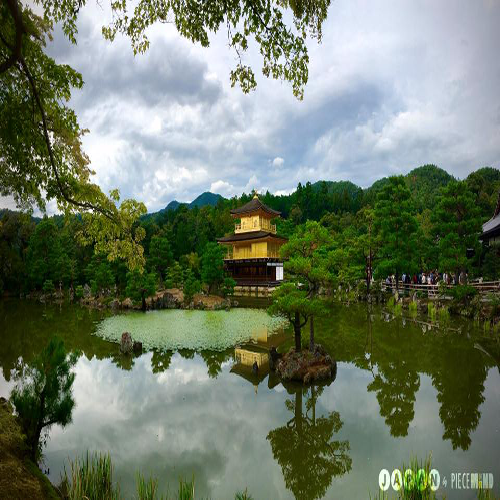

In [17]:
# Loading (And Normalizing) Content Image
contentImage = loadImage('Content.jpg', 500)
contentImageArray = normalize(contentImage)
contentImage

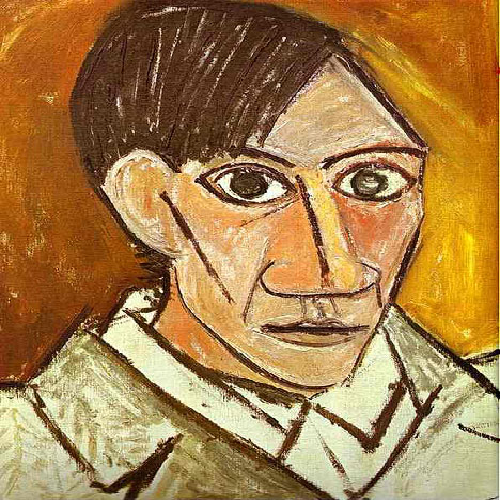

In [18]:
# Loading (And Normalizing) Style Image
styleImage = loadImage('Style.jpg', 500)
styleImageArray = normalize(styleImage)
styleImage

In [19]:
# Creating Keras Compatible Variables
styleImage = backend.variable(styleImageArray)
contentImage = backend.variable(contentImageArray)

# Initializing w/ zero vector
combinedImage = backend.placeholder((1, imageSize, imageSize, 3))

# Creating Instance of VGG-16 model
modelInput = backend.concatenate([contentImage, styleImage, combinedImage], axis=0)
model = VGG16(input_tensor = modelInput, include_top=False)

In [24]:
# Main Utility Function Declarations

def meanSquaredError(a, b):
    return backend.sum(backend.square(b - a))

def gramMatrix(image):
    flattenedMatrix = backend.batch_flatten(backend.permute_dimensions(image, (2, 0, 1)))
    dotProduct = backend.dot(flattenedMatrix, backend.transpose(flattenedMatrix))
    return dotProduct

def styleLossCalculator(styleImage, combinedImage):
    
    # Finding Gram Matrices for Style & Combined Images
    styleGram = gramMatrix(styleImage)
    combinedGram = gramMatrix(combinedImage)
    
    # Declaring Image Size
    size = imageSize * imageSize
    
    return backend.sum(backend.square(styleGram - combinedGram)) / (4.0 * (3 ** 2) * (size ** 2))

def totalLossCalculator(image):
    
    # Finding Respective Content & Style Losses
    contentLoss = backend.square(image[:, :imageSize-1, :imageSize-1, :] - image[:, 1:, :imageSize-1, :])
    styleLoss = backend.square(image[:, :imageSize-1, :imageSize-1, :] - image[:, :imageSize-1, 1:, :])
    
    return backend.sum(backend.pow(contentLoss + styleLoss, totalVariationLoss))

In [25]:
# Creating Dictionary for Layer Representation
layerDictionary = dict([(l.name, l.output) for l in model.layers])

# Declaring Layers
contentLayer = "block2_conv2"
styleLayers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
styleLayersLength = len(styleLayers)

# Extracting & Calculating Content Loss
layerExtraction = layerDictionary[contentLayer]
contentImageFeatures = layerExtraction[0, :, :, :]
combinedImageFeatures = layerExtraction[2, :, :, :]

totalLoss = backend.variable(0.)
totalLoss = totalLoss + contentWeight * meanSquaredError(contentImageFeatures, combinedImageFeatures)

# Extracting & Calculating Style Loss

for layer in styleLayers:
    layerExtraction = layerDictionary[layer]
    
    styleImageFeatures = layerExtraction[1, :, :, :]
    combinedImageFeatures = layerExtraction[2, :, :, :]
    
    styleLoss = styleLossCalculator(styleImageFeatures, combinedImageFeatures)
    
    totalLoss += (styleWeight / styleLayersLength) * styleLoss

# Calculating & Adding Total Variation Loss
totalLoss += totalVariationWeight * totalLossCalculator(combinedImage)

In [ ]:
outputs = [totalLoss]
outputs += backend.gradients(totalLoss, combinedImage)

In [27]:
def evaluate_loss_and_gradients(imageArray):
    
    imageArray = imageArray.reshape((1, imageSize, imageSize, 3))
    
    outs = backend.function([combinedImage], outputs)([imageArray])
    totalLoss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return totalLoss, gradients

class Evaluator:
    def loss(self, imageArray):
        loss, gradients = evaluate_loss_and_gradients(imageArray)
        self._gradients = gradients
        return loss

    def gradients(self, imageArray):
        return self._gradients
    
evaluator = Evaluator()

# Generate Content
Trained Over 10 Iterations w/ a Content Weight of 0.02 (And Style Weight Of Zero)


Iteration 0 completed with total loss 5700343296
Iteration 1 completed with total loss 4085023744
Iteration 2 completed with total loss 3576985600
Iteration 3 completed with total loss 3333978112
Iteration 4 completed with total loss 3181413376
Iteration 5 completed with total loss 3067191808
Iteration 6 completed with total loss 2979488256
Iteration 7 completed with total loss 2907553792
Iteration 8 completed with total loss 2847834112
Iteration 9 completed with total loss 2791747072


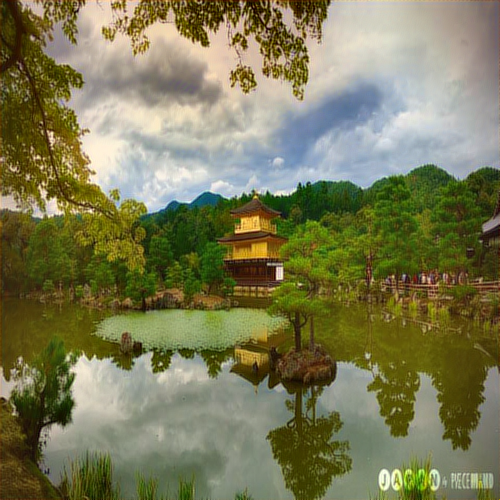

In [28]:
tempImageArray = numpy.random.uniform(0, 255, (1, imageSize, imageSize, 3)) - 128.

# Running Iterations & Calculating Total Loss & Image Array (Of Pixels) At Each Step
for i in range(iterations):
    tempImageArray, totalLoss, info = fmin_l_bfgs_b(evaluator.loss, tempImageArray.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with total loss %d" % (i, totalLoss))
    
tempImageArray = tempImageArray.reshape((imageSize, imageSize, 3))
tempImageArray = tempImageArray[:, :, ::-1]

# Normalizing Back To Origninal RGB Values (And Clipping Out-Of-Boundary Values)
tempImageArray[:, :, 0] += meanRGBValues[2]
tempImageArray[:, :, 1] += meanRGBValues[1]
tempImageArray[:, :, 2] += meanRGBValues[0]
tempImageArray = numpy.clip(tempImageArray, 0, 255).astype("uint8")

outputImage = Image.fromarray(tempImageArray)
outputImage

# Generate Style
Trained Over 5 Iterations w/ a Style Weight of 4.5 (And Content Weight of 0.02)

Iteration 0 completed with total loss 5710163456
Iteration 1 completed with total loss 4078335232
Iteration 2 completed with total loss 3563363584
Iteration 3 completed with total loss 3321340928
Iteration 4 completed with total loss 3172276736


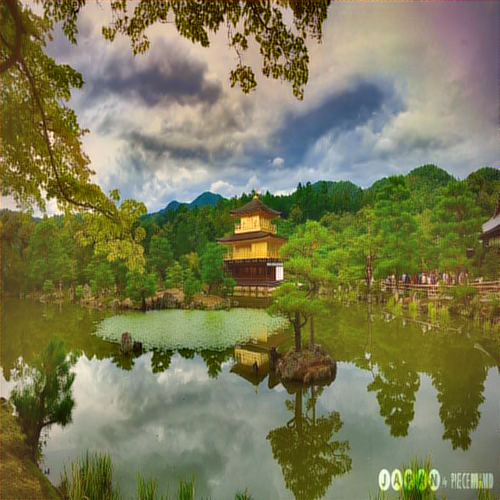

In [30]:
tempImageArray = numpy.random.uniform(0, 255, (1, imageSize, imageSize, 3)) - 128.

# Running Iterations & Calculating Total Loss & Image Array (Of Pixels) At Each Step
for i in range(iterations):
    tempImageArray, totalLoss, info = fmin_l_bfgs_b(evaluator.loss, tempImageArray.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with total loss %d" % (i, totalLoss))
    
tempImageArray = tempImageArray.reshape((imageSize, imageSize, 3))
tempImageArray = tempImageArray[:, :, ::-1]

# Normalizing Back To Origninal RGB Values (And Clipping Out-Of-Boundary Values)
tempImageArray[:, :, 0] += meanRGBValues[2]
tempImageArray[:, :, 1] += meanRGBValues[1]
tempImageArray[:, :, 2] += meanRGBValues[0]
tempImageArray = numpy.clip(tempImageArray, 0, 255).astype("uint8")

outputImage = Image.fromarray(tempImageArray)
outputImage

# Approach

- We first load & normalize the style & content images respectively.
- Then we load an instance of the pretrained VGG-16 (CNN) model, and feed the normalized images.
- We then seperate & extract the content & style layers individually.
- Then at each iteration, we try calculating & minimizing the losses (content, style, & total variation).
- Finally, we set the appropriate gradients and constantly optimize the loss functions.

# Learnings

With the help of this excersize, I was able to understand the mechanisms & workings of a CNN, and I learnt how pre-trained models integrate w/ newly introduced inputs. I also learnt how to work with tensorflow & keras.